# Working with data 2018. Class 9
## Contact
Javier Garcia-Bernardo
garcia@uva.nl

## Linear regression

In [26]:
##Some code to run at the beginning of the file, to be able to show images in the notebook
##Don't worry about this cell

#Print the plots in this screen
%matplotlib inline 

#Be able to plot images saved in the hard drive
from IPython.display import Image 

#Make the notebook wider
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:90% !important; }</style>"))

import seaborn as sns
import pylab as plt
import pandas as pd
import numpy as np
import scipy.stats

import statsmodels.formula.api as smf

In [27]:
def qq_plot(x):
    (osm, osr),(slope, intercept, r)  = scipy.stats.probplot(x, dist='norm', plot=None)
    plt.plot(osm, osr, '.', osm, slope*osm + intercept)
    plt.xlabel('Quantiles',fontsize=14)
    plt.ylabel('Quantiles Obs',fontsize=14)  

# 1. Linear Regression
## 1.1 Assumptions

- Base: i.i.d. (independent and identically distributed) residuals. This comes from the data collection:
    - Each observation is independent
    - There are no subpopulations in the population


- A) Linearity and additive terms: 
    - Check: Residuals vs fitted values, also the cond number is affected
    - Solution if it doesn't hold: Transform variables (e.g. log(x)) or add interaction terms.
- B) No autocorrealtion in residuals:
    - Check: The Durbin – Watson (DW) statistic should be close to 2
    - Solution: Add/Drop a variable. Use panel models.
- C) Homoskedasticity (the residuals must have constant variances).
    - Check: Residuals vs fitted values. Use a correlation table.
    - Solution: Add/Drop variables
- D) Normality in the residuals:
    - Check: QQ plot
    - Solution: Transform your variables (np.log(x), np.exp(x), it depends on the shape of your distribution) Related to assumption 1 
- E) No multicollinearity (no high correlation in the independent variables):
    - Check: Condition number should be lower than 30-100
    - Solution: Drop/combine independent varialbes    
- F) No outliers
    - Check: Cook's distance
    - Solution: It depends...

- While normality of independent variables is not an assumption, it make the other assumptions easier
- For Logistic Regression, assumptions B, C and D are not required. A is linear in log-odds.

Source: https://www.analyticsvidhya.com/blog/2016/07/deeper-regression-analysis-assumptions-plots-solutions/

### Example: Check if the market capitalization of a company depends on the revenue

In [28]:
df = pd.read_csv("../8_Stats_intro_regression/data/big3_position.csv",sep="\t").dropna()
df.head()

,Company_name,Company_ID,Big3Share,Position,Revenue,Assets,Employees,MarketCap,Exchange,TypeEnt
23,"PROTEOSTASIS THERAPEUTICS, INC.",US000980301,0.00,103,4312.0,18690.0,43.0,304126.0,NASDAQ National Market,Industrial company
24,"TELIGENT, INC.",US010355758,9.75,3,44250.0,184762.0,107.0,307744.0,NASDAQ National Market,Industrial company
26,BAR HARBOR BANKSHARES,US010393663,7.22,1,53863.0,1580055.0,221.0,203279.0,NYSE MKT,Bank
27,IDEXX LABORATORIES INC,US010393723,17.10,1,1601892.0,1474993.0,6800.0,8064073.0,NASDAQ National Market,Industrial company
28,"FIRST BANCORP, INC (THE)",US010404322,9.56,1,53162.0,1559660.0,218.0,216066.0,NASDAQ National Market,Bank


## Summary gives us info about assumptions

    Normality: Jarque-Bera (smallest = better). Test is pretty robust to deviations
    Auto-correlations of residuals: Durbin-Watson: [0-4]. 2 = no auto-correlation of residuals
    Normality of residuals: Omnibus (smallest = better)
    Multicollinearity: Cond. No. (smallest = better)


In [37]:
#How to run a regression (be careful, this is wrong)
mod = smf.ols(formula='MarketCap ~ Revenue + Employees', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              MarketCap   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     1600.
Date:                Mon, 29 Jan 2018   Prob (F-statistic):               0.00
Time:                        11:28:28   Log-Likelihood:                -54630.
No. Observations:                3013   AIC:                         1.093e+05
Df Residuals:                    3010   BIC:                         1.093e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.352e+06    3.4e+05      6.907      0.0

In [38]:
#Our independent variables are highly correlated
scipy.stats.pearsonr(df["Revenue"],df["Employees"])

(0.7526631045215578, 0.0)

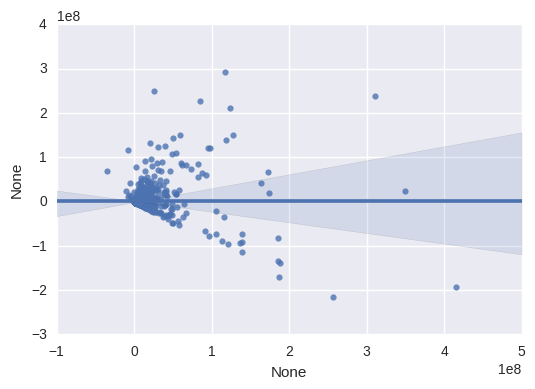

In [40]:
#Residuals vs fitted
sns.regplot(res.fittedvalues,res.resid)
#plt.scatter(res.predict(), res.resid)

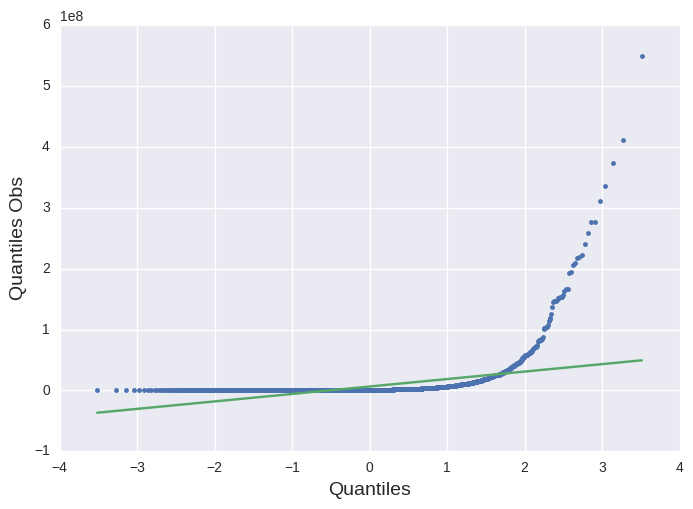

In [7]:
#And it's caused by this -> Very very far from normal, it's not additive
qq_plot(df["MarketCap"])

## Fix: Transform varialbes

In [31]:
df["log_MarketCap"] = np.log10(df["MarketCap"])
df["log_Revenue"] = np.log10(df["Revenue"])
df["log_Employees"] = np.log10(df["Employees"])
df = df.loc[np.isfinite(df["log_MarketCap"])]
df = df.loc[np.isfinite(df["log_Revenue"])]

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


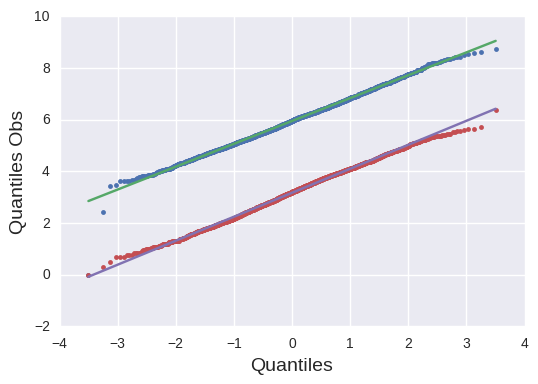

In [32]:
#And it's caused by this -> Very very far from normal, it's not additive
qq_plot(df["log_MarketCap"])
qq_plot(df["log_Employees"])

In [56]:
#This now owrks
mod = smf.ols(formula='log_MarketCap ~ log_Employees + log_Revenue ', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          log_MarketCap   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     2198.
Date:                Mon, 29 Jan 2018   Prob (F-statistic):               0.00
Time:                        11:54:38   Log-Likelihood:                -2553.8
No. Observations:                3013   AIC:                             5114.
Df Residuals:                    3010   BIC:                             5132.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.2259      0.066     33.841

# Fit diagnostiscs 


### A. Linearity and additive 
- No weird shape, regression line around zero -> Good

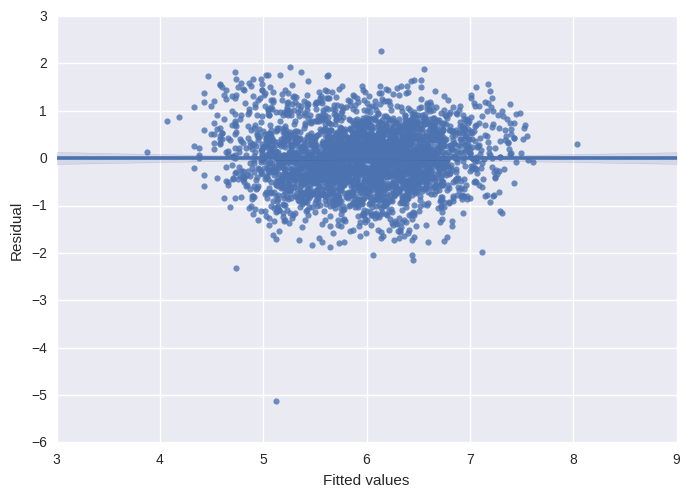

In [11]:
sns.regplot(res.predict(),res.resid)
plt.ylabel('Residual')
plt.xlabel('Fitted values')


### B. Auto-correalation
- Durbin-Watson:                   1.996 --> Good

### C. Homoskedasticity in residuals
- Residuals look good

### D. Normality in residuals
- Residuals look good

(-3, 3)

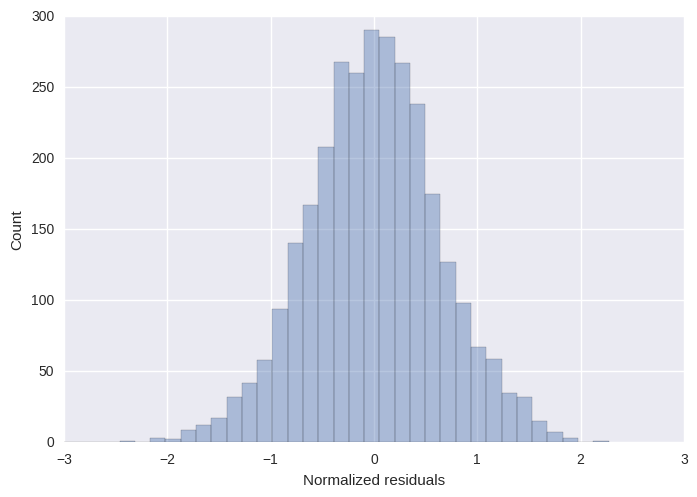

In [13]:
#Normality
sns.distplot(res.resid,kde=False)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')
plt.xlim((-3,3))

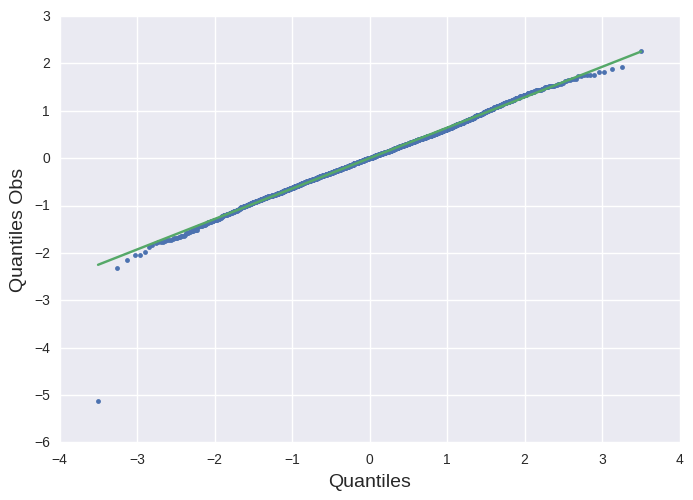

In [14]:
#Normality 2
qq_plot(res.resid)

### E. No multicollinearity among independent variables
- Cond. No. 11.8 --> Good
- Only one variable so it's okay. Otherwise a correlation plot / scatter matrix help


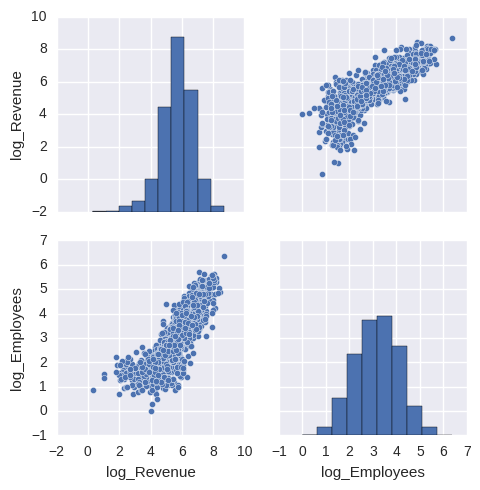

In [44]:
indep = df.loc[:,["log_Revenue","log_Employees"]]
sns.pairplot(indep)

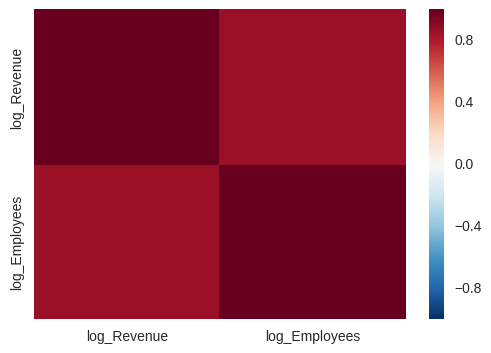

In [47]:
sns.heatmap(indep.corr(),vmin=-1,vmax=1)

### E. No outliers
    Check: Cook's distance
    Solution: It depends...


#### Cooks distance 
- Estimate of the influence of a data point when performing a least-squares regression analysis

In [50]:
pd.DataFrame([np.arange(len(c)),c]).transpose()

,0,1
0,0.0,4.364311e-04
1,1.0,8.197023e-05
2,2.0,7.268315e-06
3,3.0,1.650357e-04
4,4.0,3.567325e-06
5,5.0,2.333867e-06
6,6.0,1.351813e-04
7,7.0,9.645484e-05
8,8.0,1.109145e-03
9,9.0,4.269365e-05


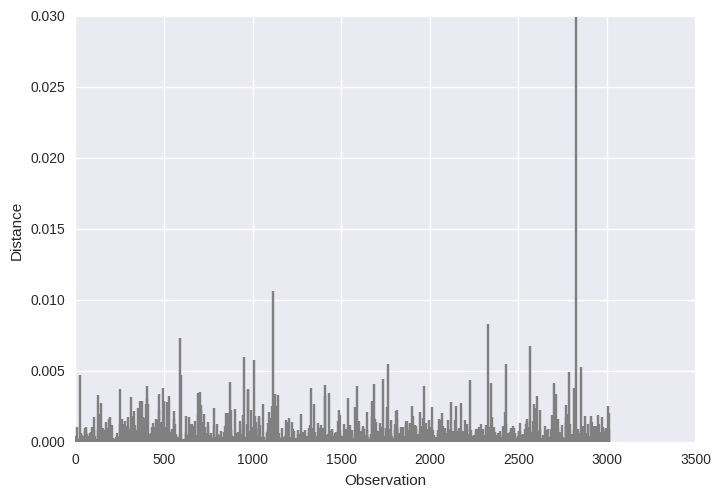

In [16]:
#Larger cook distance, larger influence
influence = res.get_influence()
(c, p) = influence.cooks_distance
plt.vlines(np.arange(len(c)), ymin=0, ymax=c,color="gray")
plt.ylabel("Distance")
plt.xlabel("Observation")

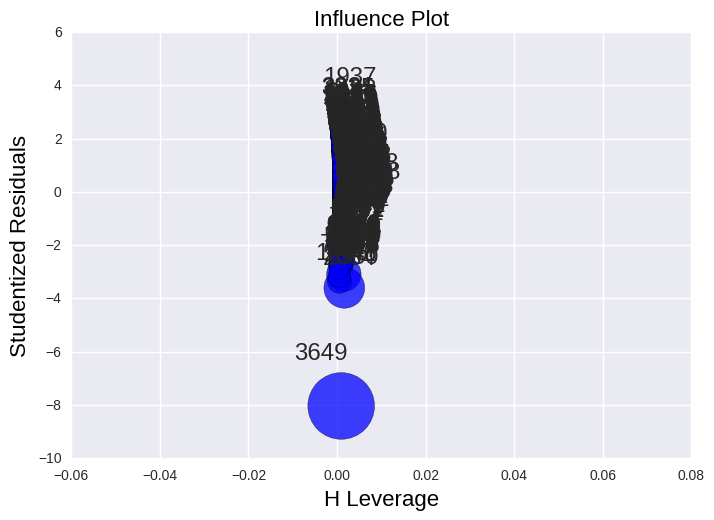

In [17]:
#Larger leverage, larger influence. 
#If high residual and high leverage -> Probably affecting the model
from statsmodels.graphics.regressionplots import *
influence_plot(res)
plt.show()


In [53]:
df.loc[3649]

Company_name                  FINET COM INC
Company_ID                      US943115180
Big3Share                                 0
Position                                100
Revenue                                7813
Assets                                17255
Employees                                81
MarketCap                                 1
Exchange         NASDAQ/NMS (Global Market)
TypeEnt                   Financial company
log_MarketCap                             0
log_Revenue                         3.89282
log_Employees                       1.90849
Name: 3649, dtype: object

#### Confidence intervals

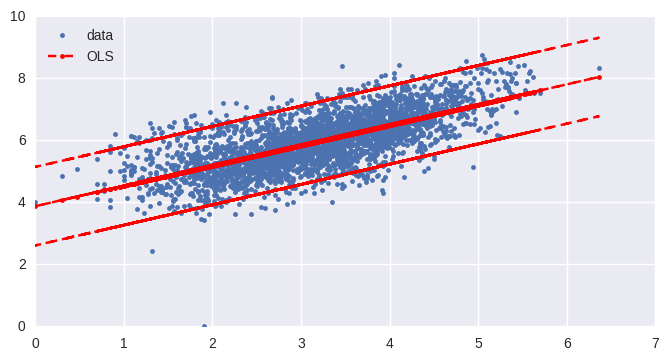

In [18]:

from statsmodels.sandbox.regression.predstd import wls_prediction_std

x = df["log_Employees"]
y = df["log_MarketCap"]
prstd, iv_l, iv_u = wls_prediction_std(res)

plt.figure(figsize=(8,4))

plt.plot(x, y, '.', label="data")
plt.plot(x, res.predict(), 'r--.', label="OLS")
plt.plot(x, iv_u, 'r--')
plt.plot(x, iv_l, 'r--')
plt.legend(loc='best')


In [ ]:
  mod = smf.ols(formula='log_MarketCap ~ log_Employees * log_Revenue + typeEnt', data=df)


More diagnostics:
http://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html

# Other types of models
- Univariate **Linear** Regression 
        mod = smf.ols(formula='log_MarketCap ~ log_Employees', data=df)
- Multivariate **Linear** Regression 
        mod = smf.ols(formula='log_MarketCap ~ log_Employees + log_Revenue', data=df)
- Multivariate **Linear** Regression with interactions
        mod = smf.ols(formula='log_MarketCap ~ log_Employees * log_Revenue', data=df)
- Multivariate **Linear** Regression with categorical data
        mod = smf.ols(formula='log_MarketCap ~ log_Employees + C(Position)', data=df)
- Multivariate **Logistic** Regression with categorical data --> In this case, the dependent variable MUST be categorical (0 or 1))
        mod = smf.logit(formula='xx ~ log_Employees + C(Position)', data=df)
- Mixed effect (**multilevel**) model with random intercepts --> In this case, there must be some groups (for instance countries)
        mod = smf.mixedlm(formula='log_MarketCap ~ log_Employees', data=df,groups="Position")
- Mixed effect (**multilevel**) model with random intercepts and random slopes
        mod = smf.mixedlm(formula='log_MarketCap ~ log_Employees', data=df,groups="Position", re_formula="Year")

## Example: Multilevel model with random intercepts

In [58]:
df = pd.read_csv("data/test_mixed.csv")
df.head()

,happiness,wealth,country
0,0.030247,0.328295,NL
1,0.059776,0.328493,NL
2,0.178334,0.349546,NL
3,0.227398,0.525887,NL
4,0.256253,0.594296,NL


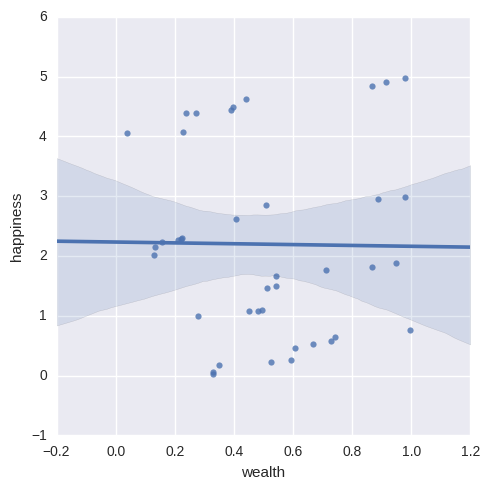

In [60]:
sns.lmplot("wealth","happiness",data=df)
plt.show()

In [61]:
mod = smf.ols(formula='happiness ~ wealth', data=df)#,groups="country")
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              happiness   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                  0.005689
Date:                Mon, 29 Jan 2018   Prob (F-statistic):              0.940
Time:                        12:42:25   Log-Likelihood:                -74.590
No. Observations:                  40   AIC:                             153.2
Df Residuals:                      38   BIC:                             156.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2322      0.541      4.127      0.0

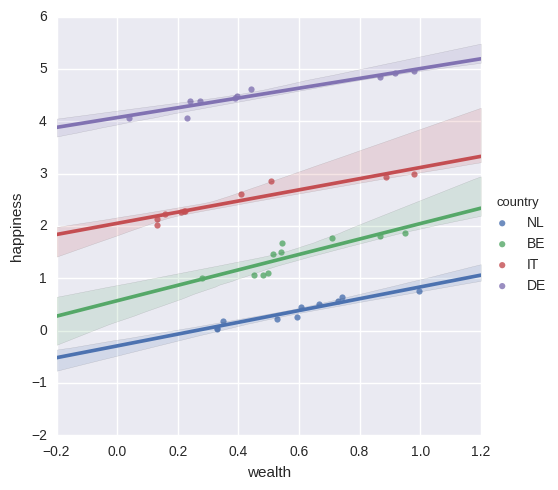

In [62]:
sns.lmplot("wealth","happiness",data=df,hue="country")
plt.show()

In [65]:
df["country"].unique()

array(['NL', 'BE', 'IT', 'DE'], dtype=object)

In [64]:

mod = smf.ols(formula='happiness ~ wealth + country', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              happiness   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1362.
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           7.08e-38
Time:                        12:43:28   Log-Likelihood:                 26.495
No. Observations:                  40   AIC:                            -42.99
Df Residuals:                      35   BIC:                            -34.55
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7994      0.064     12.509

In [66]:

mod = smf.mixedlm(formula='happiness ~ wealth ', data=df,groups="country")
res = mod.fit()
print(res.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: happiness
No. Observations: 40      Method:             REML     
No. Groups:       4       Scale:              0.0178   
Min. group size:  10      Likelihood:         8.9898   
Max. group size:  10      Converged:          Yes      
Mean group size:  10.0                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.645    0.918  1.793 0.073 -0.153  3.444
wealth        1.084    0.082 13.174 0.000  0.923  1.245
groups RE     3.359   21.433                           



In [67]:
#Get the random effects. This should be normally distributed (qqplot if many groups)
pd.DataFrame(res.random_effects)

,BE,DE,IT,NL
groups,-0.844966,2.355598,0.399507,-1.910139


In [23]:
#Now go to mixed models.